# Simple Feed forward Neural Network (using pandas dataframe)

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print('Tensorflow version:',tf.__version__)

Tensorflow version: 2.1.0


### 1.0 Preprocessing

In [2]:
# Load the data from a single CSV file
dataframe = pd.read_csv('data(4-directions).csv')

print('Total examples =', len(dataframe))
print('Unique Labels -',dataframe.DIRECTION.unique())
print('Coulmn headers -',list(dataframe.columns.values))

dataframe.head()

Total examples = 1199
Unique Labels - ['Left' 'Right' 'Front' 'Back']
Coulmn headers - ['LEFT', 'RIGHT', 'DIRECTION']


,LEFT,RIGHT,DIRECTION
0,24216.0000,11725.0625,Left
1,20136.6875,5417.7500,Left
2,19683.2500,9222.5625,Left
3,18785.6250,5948.8125,Left
4,20489.8125,7541.1250,Left


### 1.1 Convert string type columns into numerical

In [3]:
dataframe.DIRECTION = dataframe.DIRECTION.astype("category").cat.codes
dataframe.head()

,LEFT,RIGHT,DIRECTION
0,24216.0000,11725.0625,2
1,20136.6875,5417.7500,2
2,19683.2500,9222.5625,2
3,18785.6250,5948.8125,2
4,20489.8125,7541.1250,2


In [4]:
# # Standardizing.
dataframe[['LEFT', 'RIGHT']] = StandardScaler().fit_transform(dataframe[['LEFT', 'RIGHT']])
dataframe.head()

,LEFT,RIGHT,DIRECTION
0,2.119434,-0.342036,2
1,1.376200,-1.636743,2
2,1.293586,-0.855726,2
3,1.130042,-1.527731,2
4,1.440538,-1.200876,2


### 1.2 Split the dataframe into ``train`` and `test`

In [15]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train,test_size=0.2)

print('Train examples =', len(train))
print('Test examples', len(test))
print('Validation examples', len(val))

train.head()

Train examples = 767
Test examples 240
Validation examples 192


,LEFT,RIGHT,DIRECTION
176,1.933333,-1.745164,2
411,-1.113335,1.992701,3
600,0.418898,1.289174,1
377,-1.562562,2.051652,3
1050,-0.270998,1.196867,0


### 1.3 Convert ``dataframe`` into ``dataset`` using ``tf.data`` 

In [6]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    label = dataframe.pop('DIRECTION')
    ds = tf.data.Dataset.from_tensor_slices((dataframe.values, label.values))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [16]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [8]:
features, labels = next(iter(train_ds))

print(features)
print(labels)

tf.Tensor(
[[-1.03772373  1.085366  ]
 [-0.39774943  0.21442777]
 [-0.54057959  0.26503984]
 [ 0.07975172 -0.73840066]
 [ 0.65139119  0.99685581]], shape=(5, 2), dtype=float64)
tf.Tensor([3 0 1 1 1], shape=(5,), dtype=int8)


### 2.0 Compile and train a Neural Network

In [9]:
# Single layer approach ~80% accuracy
model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, input_shape=(2,), activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(train_ds,
              validation_data=val_ds,
              epochs=100,)

Train for 154 steps, validate for 39 steps
Epoch 1/100
154/154 [==============================] - 1s 5ms/step - loss: 1.3194 - accuracy: 0.3898 - val_loss: 1.1532 - val_accuracy: 0.5104
Epoch 2/100
154/154 [==============================] - 0s 2ms/step - loss: 1.0963 - accuracy: 0.5385 - val_loss: 0.9296 - val_accuracy: 0.6354
Epoch 3/100
154/154 [==============================] - 0s 2ms/step - loss: 0.9150 - accuracy: 0.6050 - val_loss: 0.8020 - val_accuracy: 0.6615
Epoch 4/100
154/154 [==============================] - 0s 2ms/step - loss: 0.8244 - accuracy: 0.6271 - val_loss: 0.7282 - val_accuracy: 0.7135
Epoch 5/100
154/154 [==============================] - 0s 2ms/step - loss: 0.7687 - accuracy: 0.6506 - val_loss: 0.6758 - val_accuracy: 0.7344
Epoch 6/100
154/154 [==============================] - 0s 2ms/step - loss: 0.7295 - accuracy: 0.6819 - val_loss: 0.6358 - val_accuracy: 0.7656
Epoch 7/100
154/154 [==============================] - 0s 2ms/step - loss: 0.6981 - accuracy: 0.700

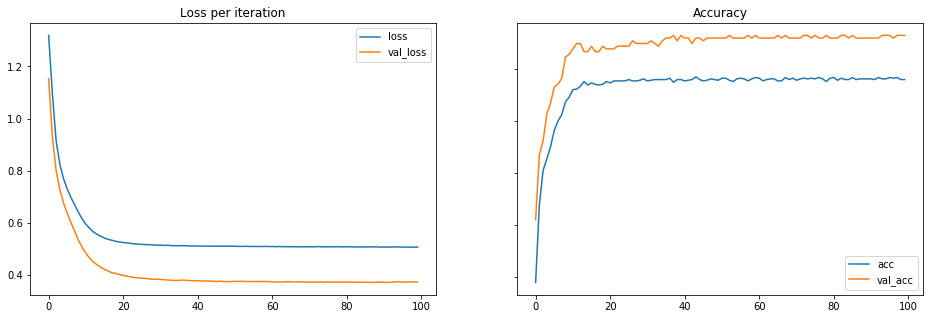

In [10]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,5))
ax1.plot(r.history['loss'], label='loss')
ax1.plot(r.history['val_loss'], label='val_loss')
ax1.legend()
ax1.set_title("Loss per iteration")
ax2.plot(r.history['accuracy'], label='acc')
ax2.plot(r.history['val_accuracy'], label='val_acc')
ax2.set_title("Accuracy")
ax2.legend()
for ax in fig.get_axes():
    ax.label_outer()
plt.show()

### 2.1 Accuracy on the Test dataset

In [11]:
loss, accuracy = model.evaluate(val_ds, verbose=2)
print("Accuracy {:.3%}".format(accuracy))

39/39 - 0s - loss: 0.3724 - accuracy: 0.8646
Accuracy 86.458%


### 3.0 Make predictions

In [34]:
predictions = model.predict(train_ds)

In [37]:
predictions[2]

array([2.2226483e-01, 2.1934105e-02, 9.2943537e-07, 7.5580019e-01],
      dtype=float32)

### 4.0 Saving the Model

In [14]:
model.save('Trained_Models/6_DirectionClassifier.h5')

### 5.0 Loading a saved Model
- This may throw an error if you explicitly create an INPUT layer. If that's the case use the following method
```
# This creats one dense layer with input shape of 2
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(1, input_shape=(2,), activation='sigmoid'))
```

In [15]:
model = tf.keras.models.load_model('6_DirectionCalssifier.h5')
print(model.layers)
model.evaluate(test_ds)

48/48 [==============================] - 0s 4ms/step - loss: 1.0187 - accuracy: 0.8125


[1.0186750727395217, 0.8125]